# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import json

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################


# Load data

In [2]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


In [3]:
## Use JSON data

In [4]:
with open('./data/stock-data-past-50-1-days.json', 'r') as f:
    data = json.loads(f.read())

df = pd.DataFrame.from_records(data['AAPL'])
df.head()


,T,v,o,c,h,l,t,n,year,month,day,hour,minute,second,dateTime,ema10,ema100,vwap,obv,rsi2
0,AAPL,2691623,147.27,146.9500,147.52,146.890,1628083800000,17987,2021,08,04,07,30,0,08/04/2021 07:30 am,nan,nan,149.334534,nan,nan
1,AAPL,1638381,146.95,147.1100,147.21,146.790,1628084100000,12904,2021,08,04,07,35,0,08/04/2021 07:35 am,nan,nan,149.337311,-45664458,nan
2,AAPL,1433748,147.16,147.5500,147.61,147.135,1628084400000,10544,2021,08,04,07,40,0,08/04/2021 07:40 am,nan,nan,149.339068,-42972835,13.92
3,AAPL,1382444,147.56,147.3453,147.78,147.240,1628084700000,11146,2021,08,04,07,45,0,08/04/2021 07:45 am,nan,nan,149.340344,-41334454,21.16
4,AAPL,1350000,147.34,147.3499,147.60,147.100,1628085000000,10363,2021,08,04,07,50,0,08/04/2021 07:50 am,nan,nan,149.341561,-42768202,74.43


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'USD')

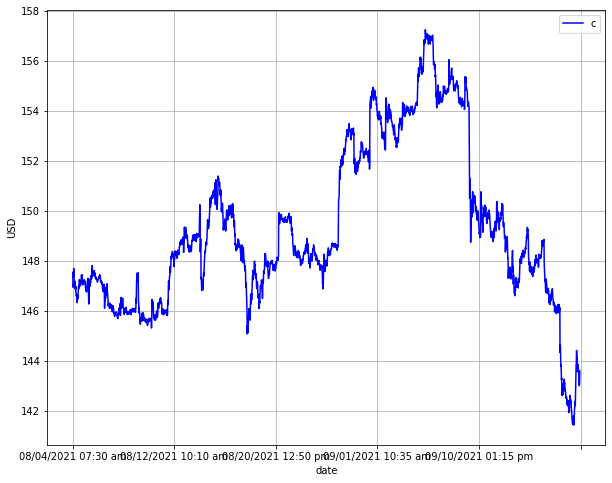

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='dateTime', y='c', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")


# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [6]:
# Get difference between high and low of each day
df['range_hl'] = df['h'] - df['l']

# Get difference between open and close of each day
df['range_oc'] = df['o'] - df['c']

df.head()

,T,v,o,c,h,l,t,n,year,month,...,minute,second,dateTime,ema10,ema100,vwap,obv,rsi2,range_hl,range_oc
0,AAPL,2691623,147.27,146.9500,147.52,146.890,1628083800000,17987,2021,08,...,30,0,08/04/2021 07:30 am,nan,nan,149.334534,nan,nan,0.630,0.3200
1,AAPL,1638381,146.95,147.1100,147.21,146.790,1628084100000,12904,2021,08,...,35,0,08/04/2021 07:35 am,nan,nan,149.337311,-45664458,nan,0.420,-0.1600
2,AAPL,1433748,147.16,147.5500,147.61,147.135,1628084400000,10544,2021,08,...,40,0,08/04/2021 07:40 am,nan,nan,149.339068,-42972835,13.92,0.475,-0.3900
3,AAPL,1382444,147.56,147.3453,147.78,147.240,1628084700000,11146,2021,08,...,45,0,08/04/2021 07:45 am,nan,nan,149.340344,-41334454,21.16,0.540,0.2147
4,AAPL,1350000,147.34,147.3499,147.60,147.100,1628085000000,10363,2021,08,...,50,0,08/04/2021 07:50 am,nan,nan,149.341561,-42768202,74.43,0.500,-0.0099


Now we use lags up to N number of days to use as features.

In [7]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['c', 'range_hl', 'range_oc', 'v']
lag_cols

['c', 'range_hl', 'range_oc', 'v']

In [8]:
shift_range = [x+1 for x in range(N)]

for shift in  tqdm(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

100%|██████████| 7/7 [00:00<00:00, 83.17it/s]


,T,v,o,c,h,l,t,n,year,month,...,range_oc_lag_5,v_lag_5,c_lag_6,range_hl_lag_6,range_oc_lag_6,v_lag_6,c_lag_7,range_hl_lag_7,range_oc_lag_7,v_lag_7
7,AAPL,924241,147.410,147.2623,147.4250,147.07,1628085900000,7755,2021,08,...,-0.3900,1433748.0,147.1100,0.420,-0.1600,1638381.0,146.9500,0.630,0.3200,2691623.0
8,AAPL,1070273,147.285,146.9701,147.3900,146.84,1628086200000,9352,2021,08,...,0.2147,1382444.0,147.5500,0.475,-0.3900,1433748.0,147.1100,0.420,-0.1600,1638381.0
9,AAPL,1167158,146.980,146.9200,147.0200,146.80,1628086500000,8312,2021,08,...,-0.0099,1350000.0,147.3453,0.540,0.2147,1382444.0,147.5500,0.475,-0.3900,1433748.0
10,AAPL,1163236,146.920,147.0400,147.0699,146.69,1628086800000,9378,2021,08,...,-0.3430,1460804.0,147.3499,0.500,-0.0099,1350000.0,147.3453,0.540,0.2147,1382444.0
11,AAPL,869028,147.035,147.0800,147.1800,146.90,1628087100000,7548,2021,08,...,0.3000,947881.0,147.6930,0.490,-0.3430,1460804.0,147.3499,0.500,-0.0099,1350000.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2491 entries, 7 to 2497
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T               2491 non-null   object 
 1   v               2491 non-null   int64  
 2   o               2491 non-null   float64
 3   c               2491 non-null   float64
 4   h               2491 non-null   float64
 5   l               2491 non-null   float64
 6   t               2491 non-null   int64  
 7   n               2491 non-null   int64  
 8   year            2491 non-null   object 
 9   month           2491 non-null   object 
 10  day             2491 non-null   object 
 11  hour            2491 non-null   object 
 12  minute          2491 non-null   object 
 13  second          2491 non-null   int64  
 14  dateTime        2491 non-null   object 
 15  ema10           2491 non-null   object 
 16  ema100          2491 non-null   object 
 17  vwap            2491 non-null   f

In [10]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [11]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Split into train, cv and test set

In [12]:
features = [
"c_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"v_lag_1",
"c_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"v_lag_2",
"c_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"v_lag_3",
"c_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"v_lag_4",
"c_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"v_lag_5",
"c_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"v_lag_6",
"c_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"v_lag_7"
]

target = "c"

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1495, 28)
y_train.shape = (1495,)
X_cv.shape = (498, 28)
y_cv.shape = (498,)
X_train_cv.shape = (1993, 28)
y_train_cv.shape = (1993,)
X_sample.shape = (498, 28)
y_sample.shape = (498,)


# EDA

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'USD')

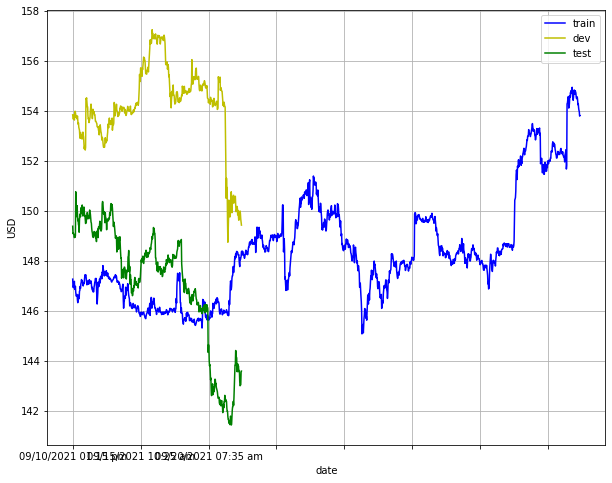

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='dateTime', y='c', style='b-', grid=True)
ax = cv.plot(x='dateTime', y='c', style='y-', grid=True, ax=ax)
ax = test.plot(x='dateTime', y='c', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Train the model using XGBoost

In [14]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

# Predict on train set

In [15]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1495 entries, 7 to 1501
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T               1495 non-null   object 
 1   v               1495 non-null   int64  
 2   o               1495 non-null   float64
 3   c               1495 non-null   float64
 4   h               1495 non-null   float64
 5   l               1495 non-null   float64
 6   t               1495 non-null   int64  
 7   n               1495 non-null   int64  
 8   year            1495 non-null   object 
 9   month           1495 non-null   object 
 10  day             1495 non-null   object 
 11  hour            1495 non-null   object 
 12  minute          1495 non-null   object 
 13  second          1495 non-null   int64  
 14  dateTime        1495 non-null   object 
 15  ema10           1495 non-null   object 
 16  ema100          1495 non-null   object 
 17  vwap            1495 non-null   f

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'USD')

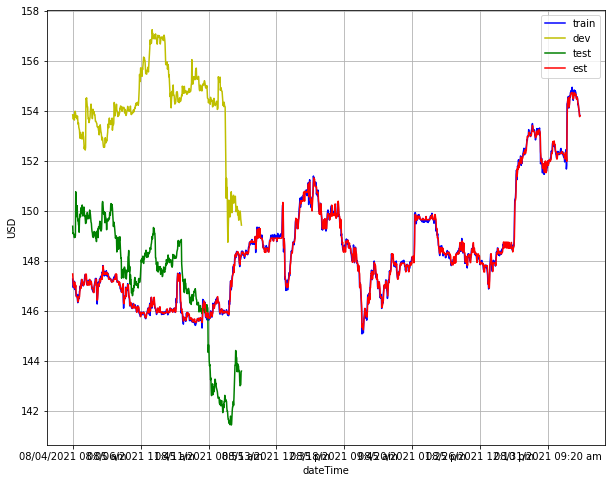

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'dateTime': train['dateTime']})

ax = train.plot(x='dateTime', y='c', style='b-', grid=True)
ax = cv.plot(x='dateTime', y='c', style='y-', grid=True, ax=ax)
ax = test.plot(x='dateTime', y='c', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='dateTime', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("dateTime")
ax.set_ylabel("USD")

# Predict on dev set

In [17]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
print("RMSE = " + str(math.sqrt(mean_squared_error(y_cv, est))))

RMSE = 0.8654903988425051


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'USD')

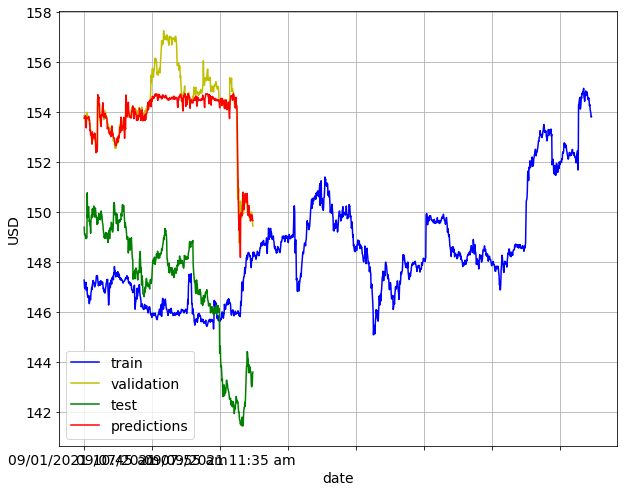

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'dateTime': cv['dateTime']})

ax = train.plot(x='dateTime', y='c', style='b-', grid=True)
ax = cv.plot(x='dateTime', y='c', style='y-', grid=True, ax=ax)
ax = test.plot(x='dateTime', y='c', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='dateTime', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")


# Findings
* Doesn't work well
* Likely because the model was trained on prices below 125 and so when it saw prices above 125 for the dev set, it could not generalize well.
* Should try to normalize the data